# Cats and dogs classifier, plus a look at overfitting and how to remove it

following this udacity colab https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c01_dogs_vs_cats_without_augmentation.ipynb#scrollTo=FE7KNzPPVrVV

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import logging

logger = tf.get_logger()
logger.setLevel(logging.DEBUG)

We use the MS Cats vs dogs dataset, here the labels are 1 and 0.
We have to download and extract the data, we can do it manually and import the data with Github or Google Drive, which is kinda tedious and data will take a while to upload to GoogleDrive or github, so it's better to just load data directly from url into the colab environment and to use the `tf.keras.preprocessing.image.ImageDataGenerator` to help us preprocess the data  
 [full dataset link(not used, too big)](https://www.kaggle.com/c/dogs-vs-cats/data)
 
  [reduced dataset link (data used for this model)](https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip)

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

68608000/68606236 [==============================] - 2s 0us/step
/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [3]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

## now we take a look at our data
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [0]:
# constants
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  #  width of 150 and height of 150 pixels for imgs

note: to learn more about this step google tensorflow input pipeline

from the colab linked above "
# Data Preparation

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.
"

In [5]:
train_image_generator      = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255)  

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Exploring our dataset

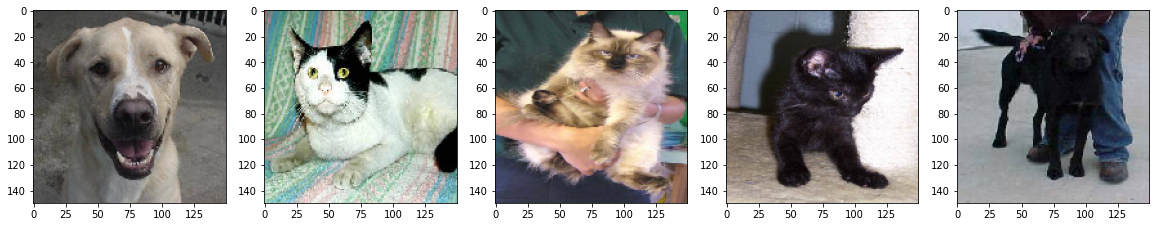

In [6]:
sample_train_imgs, sample_train_lables = next(train_data_gen)

def plotImages(img_arr):
  figs, axes = plt.subplots(1,5, figsize=(20,20))
  # axes = axes.flatten()

  for img, ax in zip(img_arr, axes):
    ax.imshow(img)
  # plt.tight_layout()
  plt.show()

plotImages(sample_train_imgs[:5])

In [7]:
from functools import partial # to make it easy to write repeating functions

activation = "relu"
filter_size = (3,3)
pool_size=(2,2) #stride=pool_size, if no arg is passed for it

conv =partial(tf.keras.layers.Conv2D, activation= activation )
pool = partial( tf.keras.layers.MaxPooling2D, pool_size = pool_size)
dense = partial(tf.keras.layers.Dense, activation = activation)

model = tf.keras.models.Sequential([
                                    conv(32,
                                         filter_size,
                                         input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
                                    pool(),

                                    conv(64, filter_size),
                                    pool(),

                                    conv(128, filter_size),
                                    pool(),

                                    tf.keras.layers.Flatten(),
                                    dense(512),
                                    tf.keras.layers.Dense(2)


])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()
# notice how the IMG_shape is 150 yet the conv input is 148, and how the maxpool
# halfs the size with those specific sizes we choose

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [8]:
EPOCHS = 100

history = model.fit(train_data_gen, 
                    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
                    epochs = EPOCHS,
                    validation_data= val_data_gen,
                     validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)



Epoch 1/100
20/20 [==============================] - 8s 407ms/step - loss: 1.1566 - accuracy: 0.4870 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 8s 412ms/step - loss: 0.6900 - accuracy: 0.5355 - val_loss: 0.6779 - val_accuracy: 0.6100
Epoch 3/100
20/20 [==============================] - 8s 413ms/step - loss: 0.6691 - accuracy: 0.6075 - val_loss: 0.6603 - val_accuracy: 0.5890
Epoch 4/100
20/20 [==============================] - 8s 409ms/step - loss: 0.6449 - accuracy: 0.6390 - val_loss: 0.6752 - val_accuracy: 0.5890
Epoch 5/100
20/20 [==============================] - 8s 410ms/step - loss: 0.6323 - accuracy: 0.6465 - val_loss: 0.6573 - val_accuracy: 0.6340
Epoch 6/100
20/20 [==============================] - 8s 409ms/step - loss: 0.6276 - accuracy: 0.6535 - val_loss: 0.7106 - val_accuracy: 0.5870
Epoch 7/100
20/20 [==============================] - 8s 406ms/step - loss: 0.5749 - accuracy: 0.6910 - val_loss: 0.6818 - val_accuracy: 0.6370

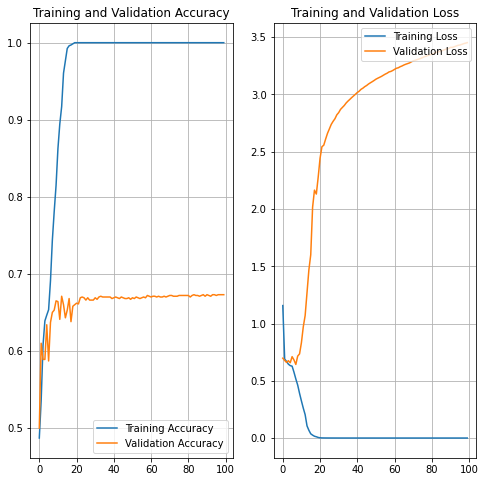

In [9]:
# wow model above reached 100% accuracy trainig and low validation acc,
# if that's not overfitting Idk what is!

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('.model_performance.png')
plt.grid()

plt.show()


#### We see how the validation accuracy is stuck at 70% and the training acc is at 100%, this is a sign of overfitting.

#### We also see (right img) that the the validation loss is skyrocketing and the training loss is almost zero. This tells us that our model is "memorizing" the training data

## For our model to be good, we need to tweak it to get the validation error down, and the validation accuracy up

## To fix it, we can use 2 techniques 1. Data augmention, and 2. Dropout layer
Data augmention, is when u apply random transformations like flipping and zooming to to training data to add varitey and make it harder for the model to memrooize the dataset. Overfitting occurs when we don't have a big enough training set, so doing this makes our model adapt to more different ways of presenting the same dog/cat.
Dropout layer turns off neruons to force weaker neruons(lesser weight) to participate more

### Data Aug

Found 2000 images belonging to 2 classes.


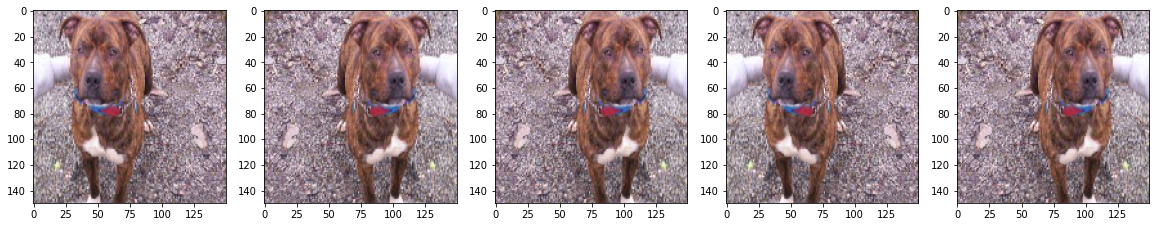

In [10]:
# we first look at # horizanatal flipping
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


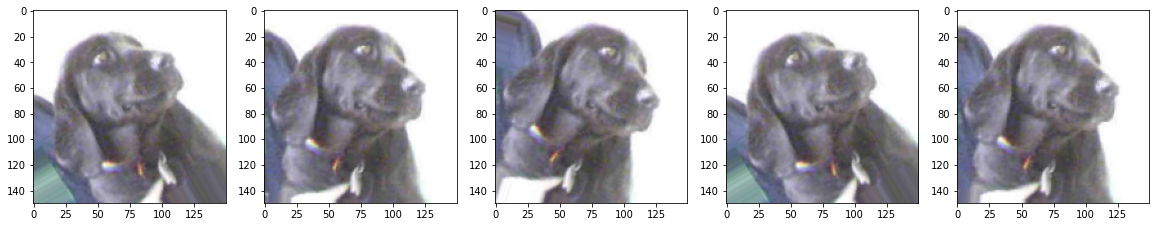

In [11]:
# Now a set of five images with rotation
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


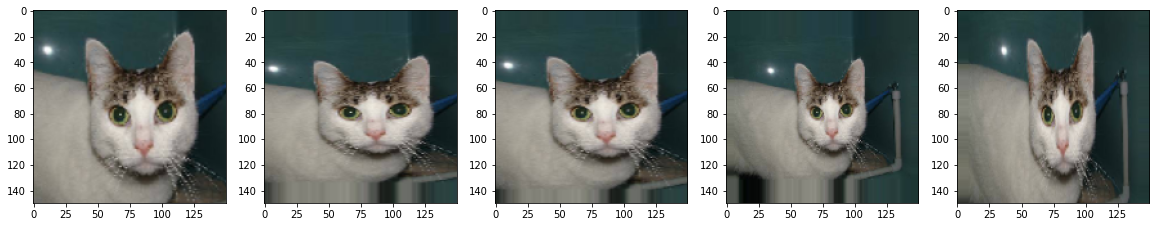

In [12]:
# Trying out zooming
# Now a set of five images with rotation
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Now Putting it all togather

Found 2000 images belonging to 2 classes.


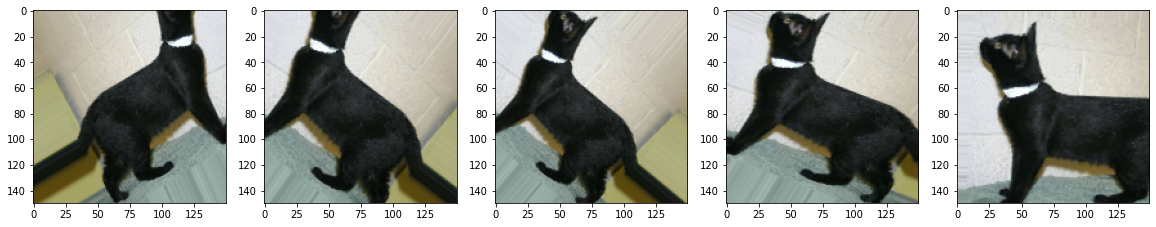

In [13]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [14]:
# The dropout layer of 50% means that 50% of the values comming into it will
 # be set to zero
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

In [15]:
history = model.fit(train_data_gen, 
                    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
                    epochs = EPOCHS,
                    validation_data= val_data_gen,
                     validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 16s 796ms/step - loss: 0.7081 - accuracy: 0.5130 - val_loss: 0.6925 - val_accuracy: 0.5760
Epoch 2/100
20/20 [==============================] - 16s 806ms/step - loss: 0.6916 - accuracy: 0.5500 - val_loss: 0.6869 - val_accuracy: 0.5900
Epoch 3/100
20/20 [==============================] - 16s 793ms/step - loss: 0.6870 - accuracy: 0.5645 - val_loss: 0.6693 - val_accuracy: 0.6080
Epoch 4/100
20/20 [==============================] - 16s 788ms/step - loss: 0.6753 - accuracy: 0.5920 - val_loss: 0.6442 - val_accuracy: 0.6360
Epoch 5/100
20/20 [==============================] - 16s 787ms/step - loss: 0.6671 - accuracy: 0.5910 - val_loss: 0.6306 - val_accuracy: 0.6670
Epoch 6/100
20/20 [==============================] - 16s 791ms/step - loss: 0.6321 - accuracy: 0.6415 - val_loss: 0.7493 - val_accuracy: 0.5830
Epoch 7/100
20/20 [==============================] - 16s 797ms/step - loss: 0.6579 - accuracy: 0.6265 - val_loss: 0.6144 - val_accuracy:

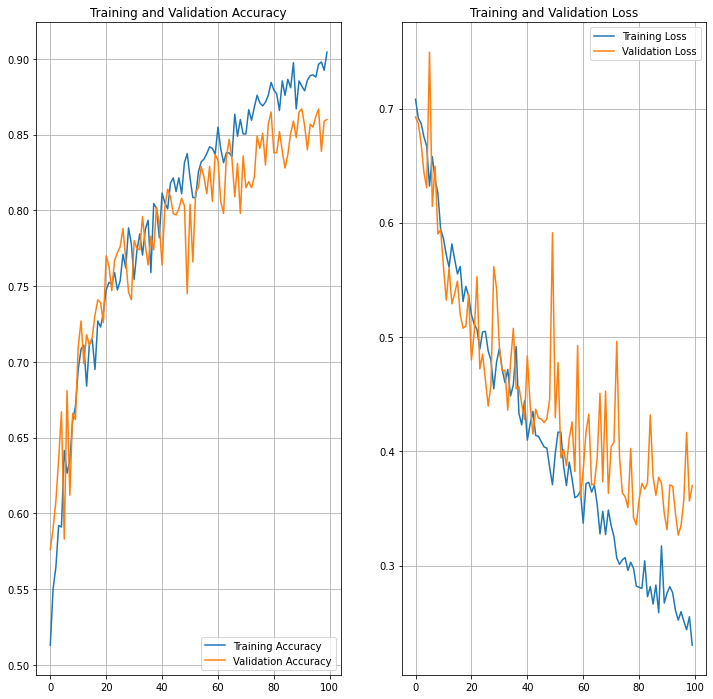

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()


plt.show()

We see that the validation accuracy has went up and validation loss went down after applying dropout layer and data augmentation. We successfully limited overfitting yay! you can go to Kaggle website and look for cats vs dogs using the same dataset and see how the first place winner did it to learn more about classification techniques. 